# Quick Start Guide

Here we show how to use some of the tools created in this repo. Let's start with the resource estimation.

## Resource Estimation
Let's construct a very simple circuit. In this case, we'll consider a VQC that contains 10 parameterised RX, RY or RZ rotations and 5 parameterised CRZ, CRY or CRZ rotations.

In [14]:
from ml_training import MlTrainingResourceEstimator, sim_ansatz, DifferentiationMethod

simple_circuit_resources = MlTrainingResourceEstimator(num_rot_gates=10, num_c_rot_gates= 5,diff_method = DifferentiationMethod.PARAMETER_SHIFT) 
simple_circuit_resources.estimate_num_training_circuits(training_set_size=1000, n_epochs=100)


4100000

Feel free to have a play with some of the parameters if you've got a circuit in mind.

We can also use some pre-made circuits, the [Sim ansatze](https://arxiv.org/abs/1905.10876). These allow us to build large standard quantum circuits quickly.

In [15]:
sim_circuit = sim_ansatz(ansatz_idx=5, n_qubits=10, layers=5)
sim_circuit_resources = MlTrainingResourceEstimator(**sim_circuit,diff_method= DifferentiationMethod.PARAMETER_SHIFT)
sim_circuit_resources.estimate_num_training_circuits(training_set_size=50000, n_epochs=20)


2201000000

This framework also allows us to estimate the time it'll take to run these calculations. For instance, if we take the time to run one of these circuits as 0.1s:

In [16]:
time_in_seconds = sim_circuit_resources.estimate_training_time_in_seconds(time_per_circuit_in_seconds=0.1,training_set_size=50000,n_epochs=20)
print(f"{time_in_seconds/(60*60*24):,.0f} days")

2,547 days


## Data Augmentation
Now let's have a play with some data augmentation techniques. The first image in this dataset is a frog. Though any will do.

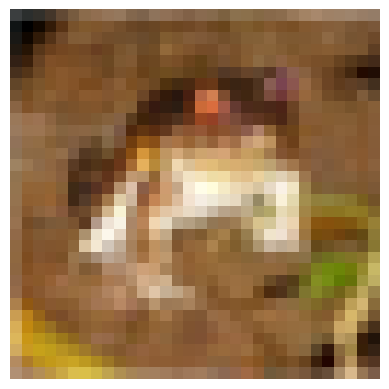

In [17]:
import matplotlib.pyplot as plt
from myrtle_torch_backend import *
from myrtle_core import *
from quantum_blur import *
from blur_transform import GaussianBlur, QuantumBlur

DATA_DIR = "../data"
dataset = cifar10(root=DATA_DIR)
img1 = dataset["train"]["data"][0]
plt.axis('off')
plt.imshow(img1)

First let's try the random cropping. Run this kernel multiple times to see how it changes the data.

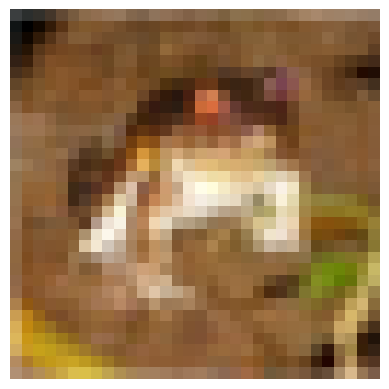

In [18]:
transforms = [partial(transpose, source="NHWC", target="NCHW")]
crop_train_set = list(zip(*preprocess(dataset["train"], [partial(pad, border=4)] + transforms).values()))
cropped_set = Transform(train_set, [Crop(32,32)])
cropped_set.set_random_choices()
plt.axis('off')
plt.imshow(colours_channel_last(cropped_set.__getitem__(0)[0]))
    

We can also try the flipping

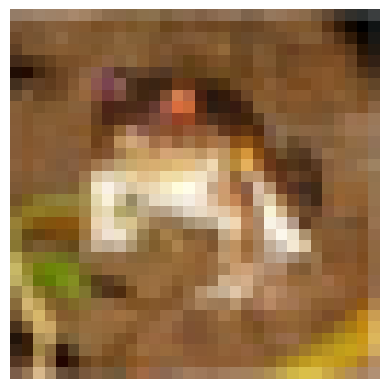

In [19]:
train_set = list(zip(*preprocess(dataset["train"], transforms).values()))
flipped_set = Transform(train_set, [FlipLR()])
flipped_set.set_random_choices()
plt.axis('off')
plt.imshow(colours_channel_last(flipped_set.__getitem__(0)[0]))
    

Cutout

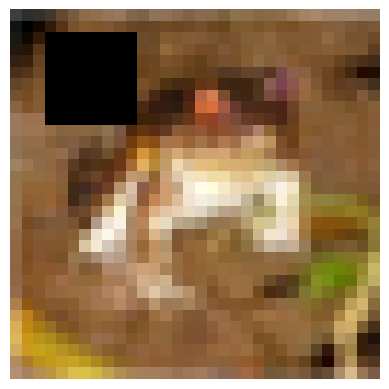

In [20]:
cutout_set = Transform(train_set, [Cutout(h=8,w=8)])
cutout_set.set_random_choices()
plt.axis('off')
plt.imshow(colours_channel_last(cutout_set.__getitem__(0)[0]))

And Gaussian blur (though this is far more subtle and could do with variance tuning).

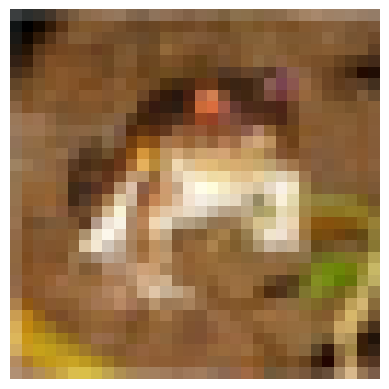

In [31]:
gaussian_blur_set = Transform(train_set, [GaussianBlur(h=8,w=8)])
gaussian_blur_set.set_random_choices()
plt.axis('off')
plt.imshow(colours_channel_last(gaussian_blur_set.__getitem__(0)[0]))

Finally, we get to Quantum Blur

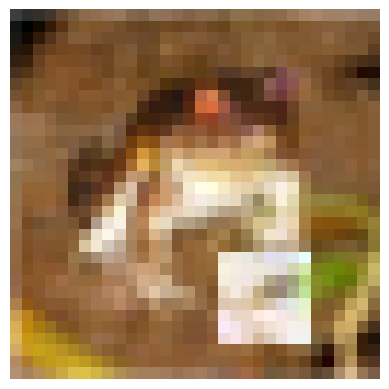

In [40]:
blur_factor = 0.1
quantum_blur_set = Transform(train_set, [QuantumBlur(h=8,w=8,alpha=blur_factor, normalise=False)])
quantum_blur_set.set_random_choices()
plt.axis('off')
plt.imshow(colours_channel_last(quantum_blur_set.__getitem__(0)[0]))

All of the heights and widths of the methods above can also be adjusted, and we can combine these methods.

In [ ]:
multiple_transforms = [Crop(32, 32), FlipLR(), Cutout(8, 8)]
multi_transform_dataset = Transform(train_set, multiple_transforms)
multi_transform_dataset.set_random_choices()
plt.axis('off')
plt.imshow(colours_channel_last(multi_transform_dataset.__getitem__(0)[0]))

## Quantum Mixup
Let's also explore how we can use mixup with images. 

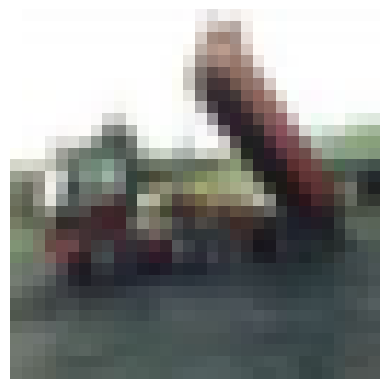

In [7]:
img2 = dataset["train"]["data"][2]
plt.axis('off')
plt.imshow(img2)

First, let's apply a classical mixup with alpha = 0.2

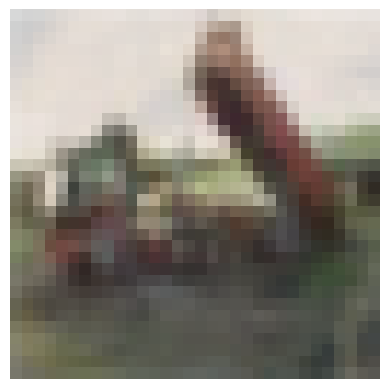

In [8]:
alpha = 0.2
plt.axis('off')
plt.imshow(np.array(img1*alpha+ img2*(1-alpha),dtype=int))

Sadly the Quantum Mixup is too resource intensive to run in this kernel, so you'll need to try out the code yourself!